In [ ]:
import os
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import diffrax as dfx
import optax
import numpy as np 
import matplotlib.pyplot as plt
import optuna
from chainconsumer import Chain, ChainConsumer

from configs import make_dirs
from configs.shear import shear
from data.shear import get_shear_experiment, get_experiment_data

from sbiax.utils import make_df
from sbiax.ndes import Ensemble, CNF, Scaler
from sbiax.train import train_ensemble
from sbiax.compression.linear import _mle
from sbiax.inference.nle import nuts_sample
from sbiax.meta import get_trial_hyperparameters

This notebook shows you how to optimise the hyperparameters for the architecture and training of a normalising flow model.

We run density-estimation SBI on a datavector made up of cosmic shear two-point functions.

Our `config` object contains all the properties of the models, training and sampling. You could use all its properties without the `config` object itself.

In [2]:
config = shear()

key = jr.key(config.seed)
key, model_key, train_key, sample_key = jr.split(key, 4)

In [3]:
# Location of results / saving
results_dir  = (
    "/Users/Jed.Homer/phd/sbiax/results/" +  # Import this from a constants file
    f"{config.sbi_type}/" + 
    f"{config.exp_name}/" + 
    f"{config.model.model_type}/" + 
    f"{config.seed}/"
)
make_dirs(results_dir)

RESULTS_DIR:
 /Users/Jed.Homer/phd/sbiax/results/nle/shear/cnf/0/


Here we sample a set of $n_s$ simulations from the true data likelihood $\mathcal{G}[\hat{\xi}|\xi[\pi], \Sigma]$ for training the normalising flow models.

In [4]:
(
    alpha,                  # True parameters
    parameter_names,        # Parameter names
    mu,                     # Model expectation
    covariance,             # Data covariance
    precision,              # Inverse data covariance
    dmu,                    # Theory derivatives
    F,                      # Fisher information
    Finv,                   # Inverse Fisher information 
    lower,                  # Lower prior bounds
    upper                   # Upper prior bounds
) = get_shear_experiment()

(
    X, 
    Y, 
    *_, # Estimated Fisher, covariance and precision (not used here)
    parameter_prior
) = get_experiment_data(
    key=key,
    good=True,
    n_sims=config.n_s,
    n_obs=1,
    results_dir=results_dir
)

In this experiment we will use a linear compression parameterised by the true data covariance $\Sigma$.

It is common in practice to use an estimate of the covariance from a finite set of simulations.

Our compression is written as $\hat{\pi} = \pi + F_{\Sigma}^{-1}E\Sigma^{-1}(\hat{\xi} - \xi[\pi])$ where $F_{\Sigma}^{-1}$ is the Fisher information matrix, $E$ is some matrix defining our model $\xi[\pi]=\pi^0 + (\pi - \pi^0)^TE$ which depends on a fiducial parameter set $\pi^0$.

Note that this implicitly assumes the model $\xi[\pi]$ is known and is perfectly accurate.

In [ ]:
s = lambda d, p: _mle(
    d,
    pi=p,
    Finv=Finv, 
    mu=mu + jnp.dot(p - alpha, dmu), 
    dmu=dmu, 
    precision=precision
)

Here we define the objective function - that takes in our training and architecture parameters - we need to optimise. 

The parameters are held in a dictionary with key access, and exactly which parameters are used depends on the model, all of which is imported from `sbiax.meta`.

The objective builds one density-estimating normalising flow, trains it, and calculates the validation loss. This loss is what `optuna` seeks to minimise.

We'll use a continuous normalising flow and put it in an `Ensemble` none the less. This object can pass through `jit` boundaries and has its own `log_prob` functions.

In [5]:
def objective(trial, params=None):
    # Objective to minimise; the fitting of a neural density estimator

    scaler = Scaler(X, Y, use_scaling=config.model.use_scaling)

    if trial is not None:
        params = get_trial_hyperparameters(trial, "cnf")

    solver = getattr(dfx, params["solver"])()

    # Build neural density estimators
    ndes = [
        CNF(
            event_dim=alpha.size, 
            context_dim=alpha.size, 
            width_size=2 ** params["width"],
            depth=params["depth"], 
            solver=solver,
            activation=config.model.activation,
            dt=params["dt"], 
            t1=config.model.t1, 
            exact_log_prob=config.model.exact_log_prob,
            scaler=scaler,
            key=model_key
        )
    ]

    ensemble = Ensemble(ndes, sbi_type=config.sbi_type)

    opt = optax.adamw(params["opt"])(params["lr"])

    ensemble, stats = train_ensemble(
        train_key, 
        ensemble,
        train_mode=config.sbi_type,
        train_data=[X, Y], 
        opt=opt,
        n_batch=params["n_batch"],
        patience=params["p"],
        n_epochs=config.n_epochs,
        trial=trial,
        show_tqdm=False,
        results_dir=results_dir
    )

    if trial is not None:
        return stats[0]["all_valid_loss"] # Loss on validation data
    else:
        return ensemble

Now we create a `storage` and `study` object which tracks the experiments run so far as well as the best hyperparameters at each point in the optimisation.

You'll see the trial progression with the validation losses, parameters that were used, and the best trial so far.

In [6]:
storage = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend(
        os.path.join(results_dir, "arch_search.log")
    )
)

study = optuna.create_study(
    study_name="hyperparameter_opt_shear",
    direction="minimize", # Minimise negative log-likelihood
    storage=storage,
    sampler=optuna.samplers.TPESampler(n_startup_trials=1),
    load_if_exists=True
) 

study.optimize(objective, n_trials=5)

df = study.trials_dataframe()
df.to_pickle(os.path.join(results_dir, "arch_search_df.pkl")) 

[I 2024-10-20 16:38:34,457] A new study created in Journal with name: hyperparameter_opt_shear


NDE has n_params=154.


[I 2024-10-20 16:41:30,328] Trial 0 finished with value: -8.118913650512695 and parameters: {'width': 7, 'depth': 1, 'dt': 0.15, 'solver': 'Tsit5', 'n_batch': 50, 'lr': 1.4973254804689393e-05, 'p': 100}. Best is trial 0 with value: -8.118913650512695.


Weights: [1.]
NDE has n_params=154.


[I 2024-10-20 16:44:19,264] Trial 1 finished with value: -8.118913650512695 and parameters: {'width': 7, 'depth': 1, 'dt': 0.15, 'solver': 'Tsit5', 'n_batch': 50, 'lr': 1.023099537308152e-05, 'p': 100}. Best is trial 0 with value: -8.118913650512695.


Weights: [1.]
NDE has n_params=51.


[I 2024-10-20 16:49:21,828] Trial 2 finished with value: -8.828324317932129 and parameters: {'width': 6, 'depth': 0, 'dt': 0.09, 'solver': 'Heun', 'n_batch': 40, 'lr': 3.119335176307966e-05, 'p': 90}. Best is trial 2 with value: -8.828324317932129.


Weights: [1.]
NDE has n_params=51.


[I 2024-10-20 16:51:28,504] Trial 3 finished with value: -4.0385212898254395 and parameters: {'width': 3, 'depth': 0, 'dt': 0.04, 'solver': 'Heun', 'n_batch': 100, 'lr': 0.0002729962730582752, 'p': 10}. Best is trial 2 with value: -8.828324317932129.


Weights: [1.]
NDE has n_params=51.


[I 2024-10-20 16:57:00,355] Trial 4 finished with value: -8.763209342956543 and parameters: {'width': 5, 'depth': 0, 'dt': 0.08, 'solver': 'Heun', 'n_batch': 40, 'lr': 5.338868853434977e-05, 'p': 60}. Best is trial 2 with value: -8.828324317932129.


Weights: [1.]


Now we grab the best parameters from the study and run the objective, returning the trained ensemble.

In [9]:
print("Number of finished trials: {}".format(len(study.trials)))

trial = study.best_trial

print(">Value: {}".format(trial.value))
print(">Number: {}".format(trial.number))
for key, value in trial.params.items():
    print("\t{} : {}".format(key, value))

Number of finished trials: 5
Best trial:
>Value: -8.828324317932129
>Number: 2
	width : 6
	depth : 0
	dt : 0.09
	solver : Heun
	n_batch : 40
	lr : 3.119335176307966e-05
	p : 90
NDE has n_params=51.
Weights: [1.]


In [ ]:
ensemble = objective(trial=None, params=trial.params)

Now we sample a measurement to condition our posterior with. This noisy datavector is from the same likelihood above, and we pass it to the `Ensemble` likelihood function.

This `log_prob` function is sampled via the `nuts_sample` function below.

In [12]:
# Get a noisy datavector with different alpha parameters
key_data, key_state, key_sample = jr.split(sample_key, 3)

# Generates datavector d ~ G[d|xi[pi], Sigma]
datavector = jr.multivariate_normal(key_data, mu, covariance)

# Linear summary
X_ = s(datavector, alpha)

# Initial state of MCMC walkers
state = jr.multivariate_normal(
    key_state, X_, Finv, (2 * config.n_walkers,)
)

ensemble = eqx.nn.inference_mode(ensemble)

log_prob_fn = ensemble.ensemble_log_prob_fn(X_, parameter_prior)

In [13]:
samples, samples_log_prob = nuts_sample(
    key_sample, log_prob_fn, prior=parameter_prior
)

Finally we plot the posterior. Nothing fancy here, we simply use `chainconsumer` to plot our chains. 

The `Ensemble` likelihood chain is compared to a Fisher forecast - which is the analytic solution to this inference problem given the Gaussian errors and linear model.

Looks reasonable. 

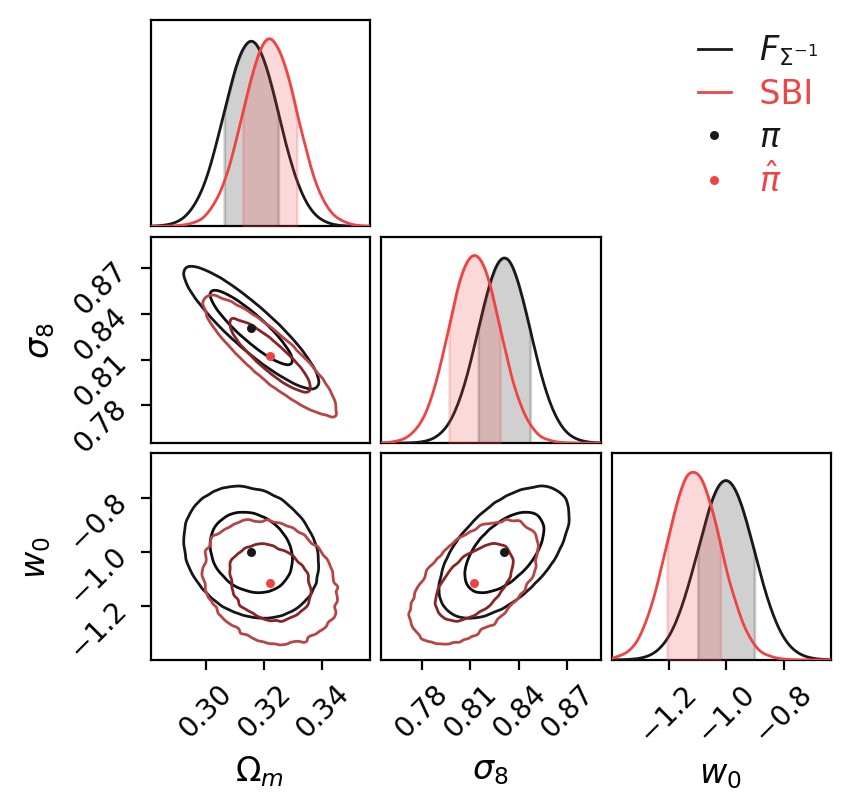

In [14]:
c = ChainConsumer()

c.add_chain(
    Chain.from_covariance(
        alpha,
        Finv,
        columns=parameter_names,
        name=r"$F_{\Sigma^{-1}}$",
        color="k",
        shade_alpha=0.
    )
)
c.add_chain(
    Chain(
        samples=make_df(samples, samples_log_prob, parameter_names), 
        name="SBI", 
        color="r", 
        shade_alpha=0.
    )
)
c.add_marker(
    location=dict(zip(parameter_names, np.asarray(alpha))), name=r"$\pi$", color="k"
)
c.add_marker(
    location=dict(zip(parameter_names, np.asarray(X_))), name=r"$\hat{\pi}$", color="r"
)

fig = c.plotter.plot()
fig.set_dpi(200)
fig.set_figheight(4.5)
fig.set_figwidth(4.5)
plt.show()